In [ ]:
import sys
!{sys.executable} -m pip install --upgrade --pre multiscale-spatial-image matplotlib itk-io


In [7]:
import os
import itk
import itkwidgets
import numpy as np
import matplotlib.pyplot as plt
import parent
import test
from test.test_all import TEST_DATA_DIR
from test.test_all import download_test_data
download_test_data()

In [ ]:
#test_volume = itk.imread(os.path.join(TEST_DATA_DIR, "colab_case/image_preprocessed.nii.gz"))
#test_volume = itk.imread('/media/pranjal.sahu/moredata/OAI-MATT/9298954_20050422_10384306_left-20220531T150108Z-001/9298954_20050422_10384306_left.nii.gz')


#test_volume = itk.imread('/media/pranjal.sahu/moredata/OAI-MATT/20051007/10101107.nii.gz')
#test_volume = itk.imread('/media/pranjal.sahu/moredata/OAI-DATASET/Package_1200013/results/18m/2.D.2/9291078/20060616/11194205_RIGHT.nii.gz')

#test_volume = itk.imread('/media/pranjal.sahu/moredata/OAI-MATT/20051007/10101103.nii.gz')
#test_volume = itk.imread('/media/pranjal.sahu/moredata/OAI-MATT/20051007/10101109.nii.gz')
#test_volume = itk.imread('/media/pranjal.sahu/moredata/OAI-MATT/20051007/10101114.nii.gz')


In [9]:
def reset_itk_image_coordinates(itkimage, origin=None, orientation=None):
    """
    Reset the origin and orientation of a given sitk image object
    :param image_file:
    :param origin:
    :param orientation:
    :return:
    """
    if origin:
        itkimage.SetOrigin(origin)
    if orientation:
        orientation = np.array(orientation).reshape([3, 3]).astype('float32')
        oritentation = itk.matrix_from_array(orientation)
        itkimage.SetDirection(orientation)
    
reset_itk_image_coordinates(test_volume, [0, 0, 0], [0, 0, -1, 1, 0, 0, 0, -1, 0])

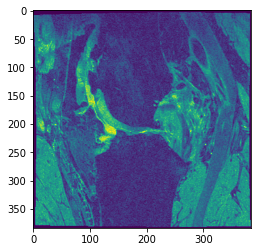

In [10]:
%matplotlib inline
tv = np.array(test_volume)
plt.imshow(tv[80])

In [11]:
itkwidgets.view(test_volume)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageF3; pro…

In [12]:
import oai_analysis_2
obj = oai_analysis_2.AnalysisObject()
FC, TC = obj.segment(test_volume)

Loading parameter file = /home/pranjal.sahu/OAI/OAI_analysis_2/data/segmentation_train_config.pth.tar
=> loading checkpoint '/home/pranjal.sahu/OAI/OAI_analysis_2/data/segmentation_model.pth.tar'
=> loaded checkpoint '/home/pranjal.sahu/OAI/OAI_analysis_2/data/segmentation_model.pth.tar' (epoch 600)


In [13]:
itkwidgets.view(FC)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageD3; pro…

In [ ]:
# Read the dicom image series

import itk
import glob
import os

dirName = '/media/pranjal.sahu/moredata/OAI-MATT/20051007/10101101'
#dirName = '/media/pranjal.sahu/moredata/OAI-MATT/9298954_20050422_10384306_left-20220531T150108Z-001/9298954_20050422_10384306_left'

def image_normalize(image, window_min_perc, window_max_perc, output_min, output_max):
    window_rescale = itk.IntensityWindowingImageFilter[type(image), type(image)].New()
    image_array = itk.GetArrayFromImage(image)
    
    window_min = np.percentile(image_array, window_min_perc)
    window_max = np.percentile(image_array, window_max_perc)
    
    window_rescale.SetInput(image)
    window_rescale.SetOutputMaximum(output_max)
    window_rescale.SetOutputMinimum(output_min)
    window_rescale.SetWindowMaximum(window_max)
    window_rescale.SetWindowMinimum(window_min)
    window_rescale.Update()
    
    return window_rescale.GetOutput()

def get_normalized_image(dirName):
    PixelType = itk.ctype("signed short")
    Dimension = 3

    ImageType = itk.Image[PixelType, Dimension]

    namesGenerator = itk.GDCMSeriesFileNames.New()
    namesGenerator.SetUseSeriesDetails(True)
    namesGenerator.AddSeriesRestriction("0008|0021")
    namesGenerator.SetGlobalWarningDisplay(False)
    namesGenerator.SetDirectory(dirName)

    seriesUID = namesGenerator.GetSeriesUIDs()
    #print(seriesUID)
    
    for uid in seriesUID:
        seriesIdentifier = uid
        fileNames = namesGenerator.GetFileNames(seriesIdentifier)

        reader  = itk.ImageSeriesReader[ImageType].New()
        dicomIO = itk.GDCMImageIO.New()
        reader.SetImageIO(dicomIO)
        reader.SetFileNames(fileNames)
        reader.ForceOrthogonalDirectionOff()
        reader.Update()
        image = reader.GetOutput()
        
        metadata = dicomIO.GetMetaDataDictionary()
        
        float_filter = itk.CastImageFilter[type(image), itk.Image.F3].New()
        float_filter.SetInput(image)
        float_filter.Update()
        image = float_filter.GetOutput()
        
        img_normalized = image_normalize(image, 0.1, 99.9, 0, 1)
        
        return img_normalized, metadata['0008|103e']
        
def reset_itk_image_coordinates(itkimage, origin=None, orientation=None):
    """
    Reset the origin and orientation of a given sitk image object
    :param image_file:
    :param origin:
    :param orientation:
    :return:
    """
    if origin:
        itkimage.SetOrigin(origin)
    if orientation:
        orientation = np.array(orientation).reshape([3, 3]).astype('float32')
        oritentation = itk.matrix_from_array(orientation)
        itkimage.SetDirection(orientation)

#folder_name = '/media/pranjal.sahu/moredata/OAI-MATT/9298954_20050422_10384306_left-20220531T150108Z-001/'
#folder_name = '/media/pranjal.sahu/moredata/OAI-MATT/20051007/'

all_folders = glob.glob('/media/pranjal.sahu/moredata/OAI-DATASET/Package_1200013/results/18m/2.D.2/*')

for folder_name in all_folders:
    #folder_name= '/media/pranjal.sahu/moredata/OAI-DATASET/Package_1200013/results/18m/2.D.2/9503347/'
    all_names = glob.glob(folder_name+'/*')
    for dirname in all_names:
        all_folders = glob.glob(dirname+'/*')
        for name in all_folders:
            #print(name)
            if os.path.isdir(name):
                #print(name)
                normalized_img, metadata = get_normalized_image(name)
                
                reset_itk_image_coordinates(normalized_img, [0, 0, 0], [0, 0, -1, 1, 0, 0, 0, -1, 0])
                
                if 'DESS' in metadata:
                    new_name =  name + '_' + metadata.split('_')[-1].strip()+'.nii.gz'
                    print(new_name, normalized_img.shape, metadata)
                    itk.imwrite(normalized_img, new_name)

In [1]:
from multiscale_spatial_image import to_multiscale, itk_image_to_multiscale, Methods
from spatial_image import is_spatial_image, to_spatial_image
import itk
import numpy as np
from urllib.request import urlretrieve
import os

In [2]:
image = itk.imread('/media/pranjal.sahu/moredata/OAI-DATASET/Package_1200013/results/18m/2.D.2/9590485/20060202/10826903_RIGHT.nii.gz')
print(image.shape)

(160, 384, 384)


In [ ]:
image_da = itk.xarray_from_image(image)
#image_da.name = image_name
print(image_da)

In [ ]:
axis_units = {dim: "millimeters" for dim in ("x", "y", "z")}
method = Methods.ITK_GAUSSIAN
scale_factors = [4, 2]  # isotropic scale factors
name = "monkey_brain"

itk.auto_progress(0)
multiscale_image = itk_image_to_multiscale(
    image,
    scale_factors=scale_factors,
    anatomical_axes=True,
    axis_units=axis_units,
    method=method,
    name=name,
)

# Result is multiscale image with three levels
print(multiscale_image)

In [2]:
from multiscale_spatial_image import to_multiscale, itk_image_to_multiscale, Methods
from spatial_image import is_spatial_image, to_spatial_image
import itk
import numpy as np
from urllib.request import urlretrieve
import os

In [4]:
# Download example image
image_name = 'monkey_brain'
filename = f'{image_name}.nrrd'
if not os.path.exists(filename):
    url = 'https://data.kitware.com/api/v1/file/564a5b078d777f7522dbfaa6/download'
    urlretrieve(url, filename)

In [5]:
image = itk.imread(filename)
print(image)

Image (0x5559f4ff3cc0)
  RTTI typeinfo:   itk::Image<short, 3u>
  Reference Count: 1
  Modified Time: 428
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 237
  UpdateMTime: 427
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [300, 350, 250]
  BufferedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [300, 350, 250]
  RequestedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [300, 350, 250]
  Spacing: [0.2734, 0.2734, 0.2734]
  Origin: [-6.835, -6.835, -6.835]
  Direction: 
1 0 0
0 1 0
0 0 1

  IndexToPointMatrix: 
0.2734 0 0
0 0.2734 0
0 0 0.2734

  PointToIndexMatrix: 
3.65764 0 0
0 3.65764 0
0 0 3.65764

  Inverse Direction: 
1 0 0
0 1 0
0 0 1

  PixelContainer: 
    ImportImageContainer (0x5559f5b76910)
      RTTI typeinfo:   itk::ImportImageContainer<unsigned long, short>
      R

In [ ]:
axis_units = {dim: "millimeters" for dim in ("x", "y", "z")}
method = Methods.ITK_GAUSSIAN
scale_factors = [4, 2]  # isotropic scale factors
name = "monkey_brain"

itk.auto_progress(0)
multiscale_image = itk_image_to_multiscale(
    image,
    scale_factors=scale_factors,
    anatomical_axes=True,
    axis_units=axis_units,
    method=method,
    name=name,
)

# Result is multiscale image with three levels
print(multiscale_image)